In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from time import strftime

import matplotlib.dates as mdates
from scipy.signal import medfilt

# %matplotlib

In [2]:
ms = [10.257, 10.3, 10.29]
bs = [-12.2, -10.2, -8.4]

LABELS = ["Baño interno", "Baño externo", "Ambiente"]

In [3]:
def loadData(file_name, time_adjust = 0):
    string = np.genfromtxt(file_name, delimiter = "\t", skip_header = 1, dtype = str)
    times = string[:, 0]
    
    times = [datetime.strptime(text, "%Y-%m-%d %H:%M:%S") - timedelta(hours = time_adjust) for text in times]
             
    data = string[:, 1:].astype(float) * 1000
    data = dataToTemperature(data)
    return times, data

def dataToTemperature(data):
    for i in range(3):
        data[:, i] = (data[:, i] - bs[i]) / ms[i]
    return data.round(2)

def plotTemperatureInTime(time, data):
    fig, ax = plt.subplots(figsize = (8, 4.5))
    for i in range(3):
        ax.plot(time, data[:, i], label = LABELS[i])

    date_format = mdates.DateFormatter('%d/%H:%M')
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis.set_minor_formatter(date_format)

    ax.legend()
    ax.set_xlabel("Hora")
    ax.set_ylabel("Temperatura ($^\circ$C)")

    fig.autofmt_xdate()
    fig.tight_layout()

    return fig, ax

def makeCompiled(time, data):
    with open("Compiled.txt", "w") as file:
        file.write("Datetime\tInner Bath (C)\tExternal Bath (C)\tAmbient (C)")
        line = [""]*4
        for (t, d) in zip(time, data):
            line[0] = t.strftime("%Y-%m-%d %H:%M:%S")
            line[1:] = ["%.2f"%val for val in d]
            file.write("\t".join(line) + "\r\n")
            
def unify(files, times):
    times_ = np.zeros((0))
    datas = np.zeros((0, 3))
    for (file, time) in zip(files, times):
        t, d = loadData(file, time)
        times_ = np.append(times_, t)
        datas = np.append(datas, d, axis = 0)
    return times_, datas

In [4]:
time, data = unify(["First.txt", "Second.txt", "Third.txt", "Fourth.txt"], [5, 5, -2, -2])

In [5]:
data = medfilt(data, kernel_size = [101, 1])

data[11000 : 12500, 0] = data[11000, 0]

In [6]:
makeCompiled(time, data)

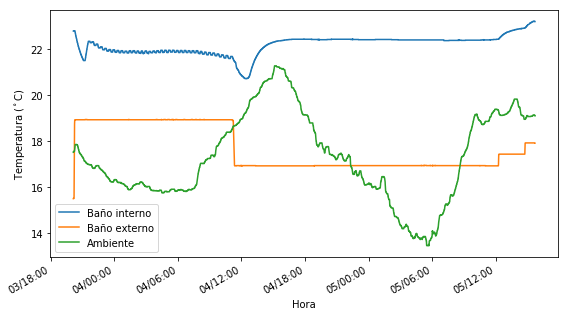

In [7]:
fig, ax = plotTemperatureInTime(time, data)
fig.savefig("Stability.png", dpi = 300)
plt.show()